# Homework 7
This assignment covers the Luas-Kanade tracking method. Please hand in `motion.py` and this notebook file to Gradescope.

In [1]:
from __future__ import print_function

# Setup
import numpy as np
from skimage import filters
from skimage.feature import corner_peaks
import matplotlib.pyplot as plt
from matplotlib import rc
from IPython.display import HTML

%matplotlib inline
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading extenrnal modules
%load_ext autoreload
%autoreload 2

## 0. Displaying Video
We have done some cool stuff with static images in past assignemnts. Now, let's turn our attention to videos! For this assignment, the videos are provided as time series of images. We also provide utility functions to load the image frames and visualize them as a short video clip.

*Note: You may need to install video codec like [FFmpeg](http://ffmpeg.zeranoe.com/builds/). If you have conda (or Anaconda), you can generally install it with `conda install -c conda-forge ffmpeg`. For Linux/Mac, you will also be able to install ffmpeg using `apt-get` or `brew`. For Windows, you can find the installation instructions [here](https://www.wikihow.com/Install-FFmpeg-on-Windows).*

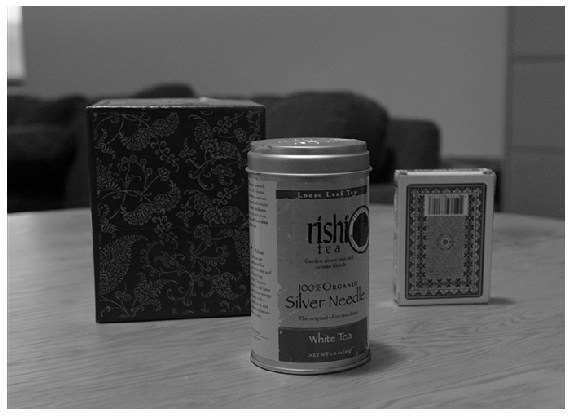

In [2]:
from utils import animated_frames, load_frames
frames = load_frames('images')
ani = animated_frames(frames)
HTML(ani.to_html5_video())

## 1. Lucas-Kanade Method for Optical Flow

### 1.1 Deriving optical flow equation
Optical flow methods are used to estimate motion of objects between two consecutive image frames. For example, in the video above, the can of tea seems to be moving to the left. For our system to be able to understand that the can is moving to the left, it would be useful to find a way to add vectors to the can (known as **flow vectors**) which point to the left, thus describing its motion.

Given two consecutive frames, how can we find the flow vectors for the first frame which describe how objects move between frames? To start, we make a reasonable assumption called the **brightness constancy** assumption: the pixel intensity of a moving point stays the same between two consecutive frames with small time differences. In other words, picking any pixel of the moving can, its brightness stays approximately the same between frames &mdash; its movement should not affect its brightness after all.

Consider pixel intensity (a.k.a. brightness) $I(x, y, t)$ of a point $(x, y)$ in the first frame $t$. Suppose that the point has moved to $(x+\Delta{x}, y+\Delta{y})$ after $\Delta{t}$. According to the brightness constancy assumption, we can relate intensities of the point in the two frames using the following equation:

$$
I(x,y,t)=I(x+\Delta{x},y+\Delta{y},t+\Delta{t})
$$

Coming back to the example of the moving can, this equation simply states that the point that we picked will have the same intensity even after it moves in space $(\Delta{x}$ and $\Delta{y})$ and between frames $(\Delta{t})$. From this simple assumption, we can derive what is known as the **optical flow equation**. For a given point for any frame, the optical flow equation is given by:

$$
I_x({\mathbf{p}})v_{x} +
I_y({\mathbf{p}})v_{y} +
I_t({\mathbf{p}})
= 0
$$

Here, $I_x$, $I_y$ and $I_t$ are partial derivatives of pixel intensity $I$. Meanwhile,
$v_{x}$ and $v_{y}$ are **flow vectors** in the $x-$ and $y-$direction, respectively. These are the vectors we care about! If we can solve for these two values, we will be able to describe the motion of any object between frames.

You might be wondering how we went from the brightness constantcy assumption to the optical flow equation. Try to derive it yourself!

- **a.** Using a first-order Taylor approximation, derive the optical flow equation from the brightness constancy equation.


- **b.** Can the optical flow equation be solved given two consecutive frames without further assumption? Of $I_x, I_y, I_t, v_x,$ and $v_y$, which values can be computed directly given two consecutive frames? Which values cannot be computed without additional information?

**Your answer here:** Write your answer in this markdown cell

### 1.2 Overview of Lucas-Kanade method

One issue with the optical flow equation is that there are two unknowns that we want to solve for ($v_x$ and $v_y$). This problem is known as the **aperture problem**. In other words, just looking an "aperture" at one pixel at a time, it is impossible to discern the true direction of motion of the object in question.

The Lucas–Kanade method solves this problem by adding another assumption: **spatial coherence**. That is, that the motion of the image contents between two frames is approximately constant within a neighborhood of the point $p$ under consideration.

Consider a neighborhood of $p$, $N(p)=\{p_1,...,p_n\}$ (e.g. 3x3 window around $p$). Adding the spatial coherence assumption to the optical flow equation, we see that the following should be satisfied:

For every $p_i \in N(p)$,
$$
I_{x}(p_i)v_x + I_{y}(p_i)v_y = -I_{t}(p_i)
$$

These equations can be written in matrix form $Av=b$, where

$$
A = 
\begin{bmatrix}
    I_{x}(p_1) & I_{y}(p_1)\\
    I_{x}(p_2) & I_{y}(p_2)\\
    \vdots & \vdots\\
    I_{x}(p_n) & I_{y}(p_n)
\end{bmatrix}
\quad
v =
\begin{bmatrix}
    v_{x}\\
    v_{y}
\end{bmatrix}
\quad
b =
\begin{bmatrix}
    -I_{t}(p_1)\\
    -I_{t}(p_2)\\
    \vdots\\
    -I_{t}(p_n)
\end{bmatrix}
$$

We can now solve for the flow vectors (now represented as $v$) by solving the following least-squares problem: $A^{T}Av=A^{T}b$.

- **a.** What is the condition for this equation to be solvable?
- **b.** Reason about why Harris corners might be good features to track using Lucas-Kanade method.

**Your answer here:** Write your answer in this markdown cell

### 1.3 Implementation of Lucas-Kanade method

In this section, we are going to implement basic Lucas-Kanade method for feature tracking. In order to do so, we first need to find keypoints to track. Harris corner detector is commonly used to initialize the keypoints to track with Lucas-Kanade method. For this assignment, we are going to use [`skimage` implementation](http://scikit-image.org/docs/dev/auto_examples/features_detection/plot_corner.html) of Harris corner detector.

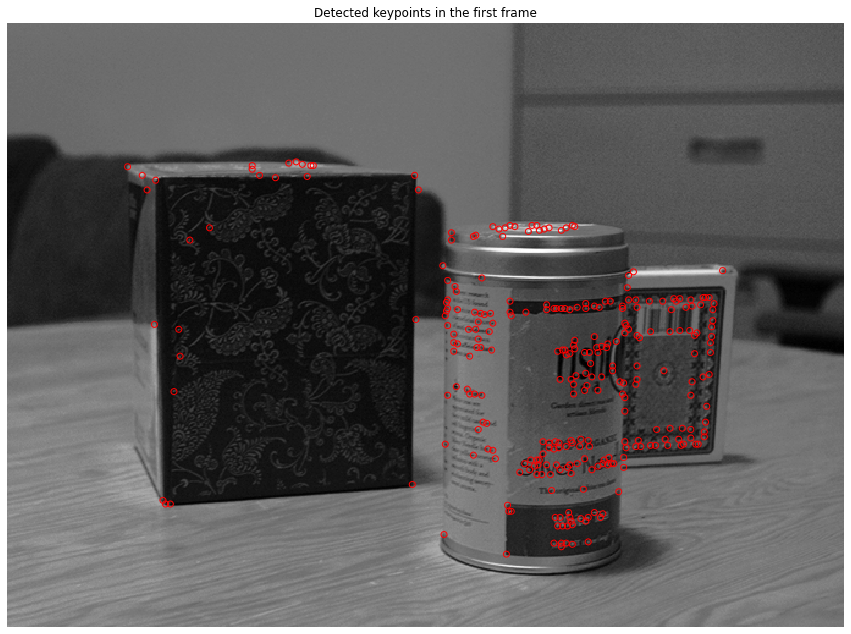

In [3]:
from skimage import filters
from skimage.feature import corner_harris, corner_peaks

frames = load_frames('images')

# Detect keypoints to track
keypoints = corner_peaks(corner_harris(frames[0]),
                         exclude_border=5,
                         threshold_rel=0.01)

# Plot kepoints
plt.figure(figsize=(15,12))
plt.imshow(frames[0])
plt.scatter(keypoints[:,1], keypoints[:,0],
            facecolors='none', edgecolors='r')
plt.axis('off')
plt.title('Detected keypoints in the first frame')
plt.show()

Implement function **`lucas_kanade`** in `motion.py` and run the code cell below. You will be able to see small arrows pointing towards the directions where keypoints are moving.

The expected output is:
![ref_imgs/optical_flow_vectors.png](ref_imgs/optical_flow_vectors.png)

ValueError: all the input arrays must have same number of dimensions, but the array at index 0 has 2 dimension(s) and the array at index 1 has 1 dimension(s)

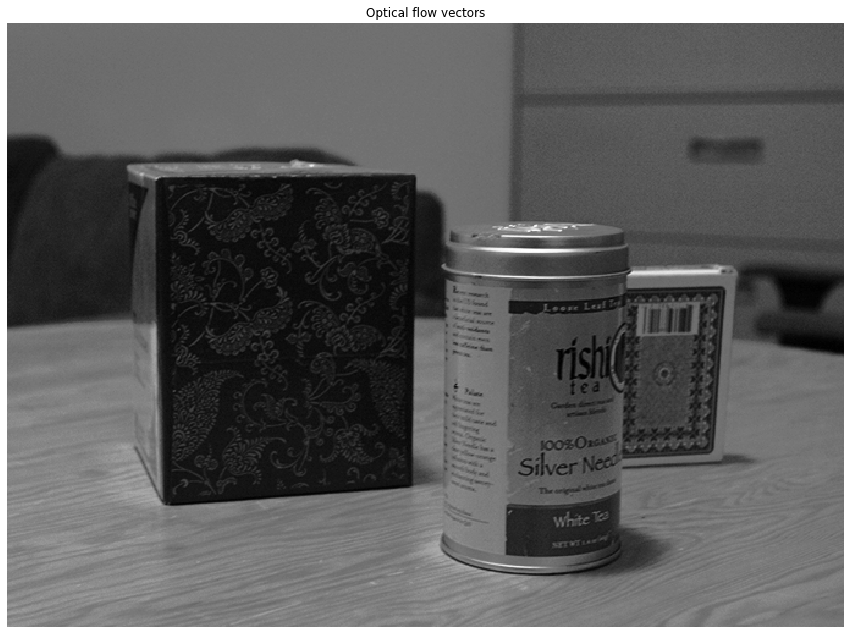

In [4]:
from motion import lucas_kanade

# Lucas-Kanade method for optical flow
flow_vectors = lucas_kanade(frames[0], frames[1], keypoints, window_size=5)

# Plot flow vectors
plt.figure(figsize=(15,12))
plt.imshow(frames[0])
plt.axis('off')
plt.title('Optical flow vectors')

for y, x, vy, vx in np.hstack((keypoints, flow_vectors)):
    plt.arrow(x, y, vx, vy, head_width=5, head_length=5, color='b')
    

We can estimate the position of the keypoints in the next frame by adding the flow vectors to the keypoints. 

The expected output is:
![ref_imgs/second_frame_tracked_keypoints.png](ref_imgs/second_frame_tracked_keypoints.png)

In [ ]:
# Plot tracked kepoints
new_keypoints = keypoints + flow_vectors
plt.figure(figsize=(15,12))
plt.imshow(frames[1])
plt.scatter(new_keypoints[:,1], new_keypoints[:,0],
            facecolors='none', edgecolors='r')
plt.axis('off')
plt.title('Tracked keypoints in the second frame')
plt.show()

### 1.4 Feature Tracking in multiple frames
Now we can use Lucas-Kanade method to track keypoints across multiple frames. The idea is simple: compute flow vectors at keypoints in $i$-th frame, and add the flow vectors to the points to keep track of the points in $i+1$-th frame. We have provided the function `track_features` for you. First, run the code cell below. You will notice that some of the points just drift away and are not tracked very well.

Instead of keeping these 'bad' tracks, we would want to somehow declare some points are 'lost' and just discard them. One simple way to is to compare the patches around tracked points in two subsequent frames. If the patch around a point is NOT similar to the patch around the corresponding point in the next frame, then we declare the point to be lost. Here, we are going to use mean squared error between two normalized patches as the criterion for lost tracks.

Implement **`compute_error`** in `motion.py`, and re-run the code cell below. You will see many of the points disappearing in later frames.

Below is what the final frame should look like:
![ref_imgs/compute_error_final_frame.png](ref_imgs/compute_error_final_frame.png)

In [ ]:
from utils import animated_scatter
from motion import track_features

# Detect keypoints to track in the first frame
keypoints = corner_peaks(corner_harris(frames[0]),
                         exclude_border=5,
                         threshold_rel=0.01)

trajs = track_features(frames, keypoints,
                       error_thresh=1.5,
                       optflow_fn=lucas_kanade,
                       window_size=5)
ani = animated_scatter(frames,trajs)
HTML(ani.to_html5_video())

## 2. Pyramidal Lucas-Kanade Feature Tracker
In this section, we are going to implement a simpler version of the method described in ["Pyramidal Implementation of the Lucas Kanade Feature Tracker"](http://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.185.585&rep=rep1&type=pdf).

### 2.1 Iterative Lucas-Kanade method
One limitation of the naive Lucas-Kanade method is that it cannot track large motions between frames. You might have noticed that the resulting flow vectors (blue arrows) in the previous section are too small that the tracked keypoints are slightly off from where they should be. In order to address this problem, we can iteratively refine the estimated optical flow vectors. Below is the step-by-step description of the algorithm:

Let $p=\begin{bmatrix}p_x & p_y \end{bmatrix}^T$ be a point on frame $I$. The goal is to find flow vector $v=\begin{bmatrix}v_x & v_y \end{bmatrix}^T$ such that $p+v$ is the corresponding point of $p$ on the next frame $J$.

- Initialize flow vector:
$$
v=
\begin{bmatrix}
    0\\0
\end{bmatrix}
$$

- Compute spatial gradient matrix:
$$
G=\sum_{x=p_x-w}^{p_x+w}\sum_{y=p_y-w}^{p_y+w}
\begin{bmatrix}
    I_{x}^2(x,y) & I_{x}(x,y)I_{y}(x,y)\\
    I_{x}(x,y)I_{y}(x,y) & I_{y}^2(x,y)
\end{bmatrix}
$$

- **for $k=1$ to $K$**
    - Compute temporal difference: $\delta I_k(x, y) = I(x,y)-J(x+g_x+v_x, y+g_y+v_y)$
    - Compute image mismatch vector:
$$
b_k=\sum_{x=p_x-w}^{p_x+w}\sum_{y=p_y-w}^{p_y+w}
\begin{bmatrix}
    \delta I_k(x, y)I_x(x,y)\\
    \delta I_k(x, y)I_y(x,y)
\end{bmatrix}
$$
    - Compute optical flow: $v^k=G^{-1}b_k$
    - Update flow vector for next iteration: $v := v + v^k$


- Return $v$

Implement `iterative_lucas_kanade` method in `motion.py` and run the code cell below. You should be able to see slightly longer arrows in the visualization.

The expected output is:
![ref_imgs/iterative_optical_flow_vectors.png](ref_imgs/iterative_optical_flow_vectors.png)

In [ ]:
from motion import iterative_lucas_kanade

# Run iterative Lucas-Kanade method
flow_vectors = iterative_lucas_kanade(frames[0], frames[1], keypoints)

# Plot flow vectors
plt.figure(figsize=(15,12))
plt.imshow(frames[0])
plt.axis('off')
plt.title('Optical flow vectors (iterative LK)')

for y, x, vy, vx in np.hstack((keypoints, flow_vectors)):
    plt.arrow(x, y, vx, vy, head_width=5, head_length=5, color='b')

Now, we will plot the tracked keypoints. 

The expected output is:
![ref_imgs/iterative_second_frame_tracked_keypoints.png](ref_imgs/iterative_second_frame_tracked_keypoints.png)

In [ ]:
# Plot tracked kepoints
new_keypoints = keypoints + flow_vectors
plt.figure(figsize=(15,12))
plt.imshow(frames[1])
plt.scatter(new_keypoints[:,1], new_keypoints[:,0],
            facecolors='none', edgecolors='r')
plt.axis('off')
plt.title('Tracked keypoints in the second frame (iterative LK)')
plt.show()

Now, we will try to track the keypoints across frames. Below is what the final frame should look like:
![ref_imgs/iterative_compute_error_final_frame.png](ref_imgs/iterative_compute_error_final_frame.png)

In [ ]:
# Detect keypoints to track in the first frame
keypoints = corner_peaks(corner_harris(frames[0]),
                         exclude_border=5,
                         threshold_rel=0.01)

# Track keypoints using iterative Lucas-Kanade method
trajs = track_features(frames, keypoints,
                       error_thresh=1.5,
                       optflow_fn=iterative_lucas_kanade,
                       window_size=5)
ani = animated_scatter(frames,trajs)
HTML(ani.to_html5_video())

### 2.2 Coarse-to-Fine Optical Flow
The iterative method still could not track larger motions. If we downscaled the images, larger displacements would become easier to track. On the otherhand, smaller motions would become more difficult to track as we lose details in the images. To address this problem, we can represent images in multi-scale, and compute flow vectors from coarse to fine scale.

Run the following code cell to visualize image pyramid.

In [ ]:
from skimage.transform import pyramid_gaussian

image = frames[0]

# pyramid_gaussian returns tuple of max_layer + 1 images in multiple scales
pyramid = tuple(pyramid_gaussian(image, max_layer=3, downscale=2))

rows, cols = image.shape
composite_image = np.zeros((rows, cols + cols // 2 + 1), dtype=np.double)
composite_image[:rows, :cols] = pyramid[0]

i_row = 0
for p in pyramid[1:]:
    n_rows, n_cols = p.shape
    composite_image[i_row:i_row + n_rows, cols:cols + n_cols] = p
    i_row += n_rows

# Display image pyramid
plt.figure(figsize=(15,12))
plt.imshow(composite_image)
plt.axis('off')
plt.show()

Following is the description of pyramidal Lucas-Kanade algorithm:

Let $p$ be a point on image $I$ and $s$ be the scale of pyramid representation.
- Build pyramid representations of $I$ and $J$: $\{I^L\}_{L=0,...,L_m}$ and $\{J^L\}_{L=0,...,L_m}$


- Initialize pyramidal guess $g^{L_m}=
\begin{bmatrix}g_{x}^{L_m} & g_{y}^{L_m}\end{bmatrix}^T=\begin{bmatrix}0 & 0\end{bmatrix}^T$


- **for $L=L_m$ to $0$ with step of -1**

    - Compute location of $p$ on $I^L$: $p^L=p/s^L$
    
    - Let $d^L$ be the optical flow vector at level $L$:
$$
d^L := IterativeLucasKanade(I^L, J^L, p^L, g^L)
$$
    - Guess for next level $L-1$: $g^{L-1}=s(g^L+d^L)$
    
    
- Return $d=g^0+d^0$

Implement `pyramid_lucas_kanade`.

The expected output is:
![ref_imgs/pyramid_optical_flow_vectors.png](ref_imgs/pyramid_optical_flow_vectors.png)

In [ ]:
from motion import pyramid_lucas_kanade

# Lucas-Kanade method for optical flow
flow_vectors = pyramid_lucas_kanade(frames[0], frames[1], keypoints)

# Plot flow vectors
plt.figure(figsize=(15,12))
plt.imshow(frames[0])
plt.axis('off')
plt.title('Optical flow vectors (pyramid LK)')

for y, x, vy, vx in np.hstack((keypoints, flow_vectors)):
    plt.arrow(x, y, vx, vy, head_width=3, head_length=3, color='b')

Now, we will plot the tracked keypoints. 

The expected output is:
![ref_imgs/pyramid_second_frame_tracked_keypoints.png](ref_imgs/pyramid_second_frame_tracked_keypoints.png)

In [ ]:
# Plot tracked kepoints
new_keypoints = keypoints + flow_vectors
plt.figure(figsize=(15,12))
plt.imshow(frames[1])
plt.scatter(new_keypoints[:,1], new_keypoints[:,0],
            facecolors='none', edgecolors='r')
plt.axis('off')
plt.title('Tracked keypoints in the second frame (pyramid LK)')

plt.show()

Now, we will try to track the keypoints across frames. Below is what the final frame should look like:
![ref_imgs/pyramid_compute_error_final_frame.png](ref_imgs/pyramid_compute_error_final_frame.png)

In [ ]:
from utils import animated_scatter
from motion import track_features
keypoints = corner_peaks(corner_harris(frames[0]),
                         exclude_border=5,
                         threshold_rel=0.01)

trajs = track_features(frames, keypoints,
                       error_thresh=1.5,
                       optflow_fn=pyramid_lucas_kanade,
                       window_size=5)
ani = animated_scatter(frames,trajs)
HTML(ani.to_html5_video())

## 3. Object Tracking
Let us build a simple object tracker using the Lucas-Kanade method we have implemented in previous sections. In order to test the object tracker, we provide you a short face-tracking sequence. Each frame in the sequence is annotated with the ground-truth location (as bounding box) of face.

An object tracker is given an object bounding box in the first frame, and it has to track the object by predicting bounding boxes in subsequent frames.

In [ ]:
from utils import animated_bbox, load_bboxes

# Load frames and ground truth bounding boxes
frames = load_frames('Man/img')
gt_bboxes = load_bboxes('Man/groundtruth_rect.txt')

ani = animated_bbox(frames, gt_bboxes)
HTML(ani.to_html5_video())

In order to track the object, we first find keypoints to track inside the bounding box. Then, we track those points in each of the following frames and output a tight bounding box around the tracked points. In order to prevent all the keypoints being lost, we detect new keypoints within the bounding box every 20 frames.

In [ ]:
# Find features to track within the bounding box
x, y, w, h = gt_bboxes[0]
roi = frames[0][y:y+h, x:x+w]
keypoints = corner_peaks(corner_harris(roi),
                         exclude_border=3,
                         threshold_rel=0.001)

# Shift keypoints by bbox offset
keypoints[:,1] += x
keypoints[:,0] += y

# Plot kepoints
plt.figure(figsize=(15,12))
plt.imshow(frames[0])
plt.scatter(keypoints[:,1], keypoints[:,0],
            facecolors='none', edgecolors='r')
plt.axis('off')
plt.show()

In [ ]:
from motion import compute_error

# Initailze keypoints abd bounding box
kp_I = keypoints
x, y, w, h = gt_bboxes[0]
bboxes = [(x, y, w, h)]

for i in range(len(frames)-1):
    I = frames[i] # current frame
    J = frames[i+1] # next frame
    
    # estimate keypoints in frame J
    flow_vectors = pyramid_lucas_kanade(I, J, kp_I)
    kp_J = kp_I + flow_vectors
    
    # Leave out lost points
    new_keypoints = []
    for yi, xi, yj, xj in np.hstack((kp_I, kp_J)):
        if yj > J.shape[0]-2 or yj < 1 or xj > J.shape[1]-2 or xj < 1:
            print('out of bound')
            continue
        else:
            patch_I = I[int(yi)-1:int(yi)+2, int(xi)-1:int(xi)+2]
            patch_J = J[int(yj)-1:int(yj)+2, int(xj)-1:int(xj)+2]
            error = compute_error(patch_I, patch_J)
            if error > 3.0:
                continue
            else:
                new_keypoints.append([yj, xj])
    
    # Update keypoints
    kp_I = np.array(new_keypoints)
    
    # Find bounding box around the keypoints
    if len(kp_I) > 0:
        x = int(kp_I[:,1].min())
        y = int(kp_I[:,0].min())
        w = int(kp_I[:,1].max()) - x
        h = int(kp_I[:,0].max()) - y
    else:
        (x, y, w, h) = (0, 0, 0, 0)
    bboxes.append((x,y,w,h))

    # Refresh keypoints every 20 frames
    if (i+1) % 20 == 0 and (w * h > 0):
        roi = J[y:y+h, x:x+w]
        new_keypoints = corner_peaks(corner_harris(roi),
                                 exclude_border=5,
                                 threshold_rel=0.01)
        new_keypoints[:,1] += x
        new_keypoints[:,0] += y
        kp_I = np.vstack((kp_I, new_keypoints))

In [ ]:
ani = animated_bbox(frames, bboxes)
HTML(ani.to_html5_video())

### 3.1 Evaluating Object Tracker: intersection over union (IoU)
Intersection over union (IoU) is a common metric for evaluating performance of an object tracker. The IoU of two bounding boxes is defined as:
$$
\text{IoU} = \frac{\text{area of intersection}}{\text{area of union}}
$$
Implement `IoU` in `motion.py` to evaluate our object tracker. With default parameters, you will get IoU score of ~0.37.

In [ ]:
from motion import IoU

average_iou = 0.0
for gt_bbox, bbox in zip(gt_bboxes, bboxes):
    average_iou += IoU(gt_bbox, bbox)
    
average_iou /= len(gt_bboxes)
print(average_iou)

## Extra Credit: Optimizing Object Tracker
Optimize the object tracker in the code cell below. You may modify the code and define new parameters. We will grant extra credit for IoU score > 0.45.

In [ ]:
from motion import compute_error

### Define your parameters here
### Describe the paramters in comments
error_thresh = 3.0
n_frames = 20


#####################################################
# You may modify the code below to use the params you
# define above.
#####################################################

# Find features to track within the bounding box
x, y, w, h = gt_bboxes[0]
roi = frames[0][y:y+h, x:x+w]
keypoints = corner_peaks(corner_harris(roi),
                         exclude_border=3,
                         threshold_rel=0.001)

# Shift keypoints by bbox offset
keypoints[:,1] += x
keypoints[:,0] += y

# Initailze keypoints and bounding box
kp_I = keypoints
x, y, w, h = gt_bboxes[0]
bboxes = [(x, y, w, h)]

# Start tracking
for i in range(len(frames)-1):
    I = frames[i] # Current frame
    J = frames[i+1] # Next frame
    flow_vectors = pyramid_lucas_kanade(I, J, kp_I) # Compute flow vectors
    kp_J = kp_I + flow_vectors # Estimate keypoints in frame J
    
    new_keypoints = []
    for yi, xi, yj, xj in np.hstack((kp_I, kp_J)):
        # keypoint falls outside the image
        if yj > J.shape[0]-2 or yj < 1 or xj > J.shape[1]-2 or xj < 1:
            print('out of bound')
            continue
        else:
            # Compute error to find lost points
            patch_I = I[int(yi)-1:int(yi)+2, int(xi)-1:int(xi)+2]
            patch_J = J[int(yj)-1:int(yj)+2, int(xj)-1:int(xj)+2]
            error = compute_error(patch_I, patch_J)
            if error > error_thresh:
                continue
            else:
                new_keypoints.append([yj, xj])
    
    # Update keypoints
    kp_I = np.array(new_keypoints)
    
    # Find bounding box around the keypoints
    if len(kp_I) > 0:
        x = int(kp_I[:,1].min())
        y = int(kp_I[:,0].min())
        w = int(kp_I[:,1].max()) - x
        h = int(kp_I[:,0].max()) - y
    else:
        (x, y, w, h) = (0, 0, 0, 0)
    bboxes.append((x,y,w,h))

    # Detect new keypoints every n_frames
    if (i+1) % n_frames == 0 and (w * h > 0):
        roi = J[y:y+h, x:x+w]
        new_keypoints = corner_peaks(corner_harris(roi),
                                 exclude_border=5,
                                 threshold_rel=0.01)
        new_keypoints[:,1] += x
        new_keypoints[:,0] += y
        kp_I = np.vstack((kp_I, new_keypoints))

In [ ]:
from motion import IoU

average_iou = 0.0
for gt_bbox, bbox in zip(gt_bboxes, bboxes):
    average_iou += IoU(gt_bbox, bbox)
    
average_iou /= len(gt_bboxes)
print(average_iou)